# Tutorial 8
By Nicholas Yap (Student of MH4518 - Semester 1 of 2023)
## Importing HSI data

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats

The below data contains daily close price of the HSI stock, which our USD Outperformance Certificate is based off, from 21 Nov 2014 to 21 Nov 2019.

In [2]:
hsi_df = pd.read_csv("HSI.csv")
display(hsi_df[hsi_df["Adj Close"].isna()])

,Date,Adj Close
416,8/2/2016,NaN
472,10/21/2016,NaN
679,8/23/2017,NaN


3 values of our imported HSI dataframe are null, which we discard from our dataframe:

In [3]:
hsi_df = hsi_df[hsi_df["Adj Close"].notna()].reset_index()
display(hsi_df)

,index,Date,Adj Close
0,0,11/21/2014,23437.12
1,1,11/24/2014,23893.14
2,2,11/25/2014,23843.91
3,3,11/26/2014,24111.98
4,4,11/27/2014,24004.28
...,...,...,...
1226,1229,11/15/2019,26326.66
1227,1230,11/18/2019,26681.09
1228,1231,11/19/2019,27093.80
1229,1232,11/20/2019,26889.61


## Estimating Model Parameters from Historical Data

Using the close prices, we calculate the following:
- Natural logarithm of the close prices
- Log-returns of the close prices

In [4]:
hsi_df["Log Close"] = np.log(hsi_df["Adj Close"])
hsi_df["Log Close"]

0       10.062076
1       10.081347
2       10.079284
3       10.090464
4       10.085987
          ...    
1226    10.178337
1227    10.191710
1228    10.207060
1229    10.199495
1230    10.183649
Name: Log Close, Length: 1231, dtype: float64

In [5]:
hsi_df["Log Return"] = 0
hsi_df["Log Return"].iloc[1:] = hsi_df["Log Close"].iloc[1:].values - hsi_df["Log Close"].iloc[:-1].values
hsi_df["Log Return"]

/tmp/ipykernel_14872/2611290712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hsi_df["Log Return"].iloc[1:] = hsi_df["Log Close"].iloc[1:].values - hsi_df["Log Close"].iloc[:-1].values
/tmp/ipykernel_14872/2611290712.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.0192703  -0.00206255  0.01117997 ...  0.01534984 -0.00756495
 -0.01584583]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hsi_df["Log Return"].iloc[1:] = hsi_df["Log Close"].iloc[1:].values - hsi_df["Log Close"].iloc[:-1].values


0       0.000000
1       0.019270
2      -0.002063
3       0.011180
4      -0.004477
          ...   
1226    0.000113
1227    0.013373
1228    0.015350
1229   -0.007565
1230   -0.015846
Name: Log Return, Length: 1231, dtype: float64

We set our time step to `1/252` (1 day out of 252 working days in a year), which we use to calculate `Hv` (mean log return / timestep) and `sigma` (standard deviation / sqrt(timestep)).

In [6]:
dt = 1/252
Hv = np.mean(hsi_df["Log Return"]) / dt
sigma = np.sqrt(np.var(hsi_df["Log Return"])) / np.sqrt(dt)

With this, we have our model parameters from our historical data. We can then proceed to generate simulations for our data.

In [7]:
display(Hv)
display(sigma)

0.024887415543858222

0.1771744842280586

## A visualization of our simulations

We define the following simulation functions below:
- `simulate_gbm_exact` - Simulation of GBM using Monte Carlo
- `simulate_gbm_exact_av` - Simulation of GBM with antithetic variates (AV)
- `simulate_gbm_1_shoot_ss` - 1-shoot simulation of GBM using stratified sampling (SS), only calculates stock price at t = T
- `simulate_gbm_ems` - Simulation of GBM using empirical Martingale simulation (EMS)

In [8]:
def simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T, collate=False):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))

    for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
    return S_t

In [9]:
def simulate_gbm_exact_av(n_sim, S_0, v, sigma, delta_t, T, collate=False):
    '''
    GBM simulation using Monte Carlo with antithetic variates

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    - collate - Boolean: True - Returns [S_t[0], S_tilde_t[0], ..., S_t[n_sim-1], S_tilde_t[n_sim-1]],
                         False - Returns [S_t[0], ..., S_t[n_sim-1], S_tilde_t[0], ..., S_tilde_t[n_sim-1]],
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    S_tilde_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))
    
    for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            # S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))

    if collate:
        collated = [None] * (2*n_sim)
        for i in range(n_sim):
            collated[2*i] = S_t[i]
            collated[2*i+1] = S_tilde_t[i]
        return collated
    S_t = np.append(S_t, S_tilde_t, 0)
    return S_t

In [10]:
def simulate_gbm_1_shoot_ss(n_strata, n_sim_s, S_0, v, sigma, T):
    '''
    GBM simulation using Monte Carlo with stratified sampling

    Takes in the following parameters:
    - n_strata (integer): No. of strata
    - n_sim_s (integer): No. of simulations to generate per strata (Total = n_strata * n_sim_s)
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - T (float): End date, used to calculate no. of periods
    '''
    V = np.random.uniform(size=n_sim_s) / n_strata
    for i in range(1, n_strata):
        V = np.append(V, (i + np.random.uniform(size=n_sim_s)) / n_strata, 0 )
    Z = np.array(scipy.stats.norm.ppf(V))
    S_T = S_0 * np.exp(v*T + sigma*np.sqrt(T)*Z)
    # S_T = S_0 * np.exp(v*T - 0.5*(sigma**2)*T + sigma*np.sqrt(T)*Z)
    return S_T.reshape(n_sim_s*n_strata, 1)

In [11]:
def simulate_gbm_ems(sim_paths, delta_t, r):
    '''
    GBM simulation using Empirical Martingale Simulation

    Takes in the following parameters:
    - sim_paths (np.array): List of paths generated from `simulate_gbm_exact`, shape: (n_sim, n_periods+1)
    - delta_t (float): Value of one timestep (e.g. 1/252, 1 day out of 252 working days in a year)
    - r (float): Risk-free interest rate
    '''
    n_sim = sim_paths.shape[0]
    n_periods = sim_paths.shape[1] - 1
    S = np.zeros((n_sim, n_periods+1))
    Z = np.zeros((n_sim+1, n_periods))
    S[:, 0] = sim_paths[:, 0]

    for j in range(1, n_periods+1):
        Z[:n_sim, j-1] = S[:,j-1]*sim_paths[:, j] / sim_paths[:, j-1]
        Z[n_sim,j-1] = np.exp(-r*((j-1)*delta_t)) * np.mean(Z[:n_sim,j-1])
        S[:,j] = sim_paths[:, 0] * Z[:n_sim, j-1] / Z[n_sim, j-1]
    return S

For illustrative purposes, we perform 10 simulations using the base Monte Carlo method starting from our latest close price (12 Nov 2019).

In [12]:
S_t = hsi_df["Adj Close"].iloc[-1]
n_sim = 10
r = 0.0155
v = r - sigma**2 / 2

In [13]:
np.random.seed(4518)
hsi_simulations = simulate_gbm_exact(n_sim, S_t, v, sigma, dt, 1)

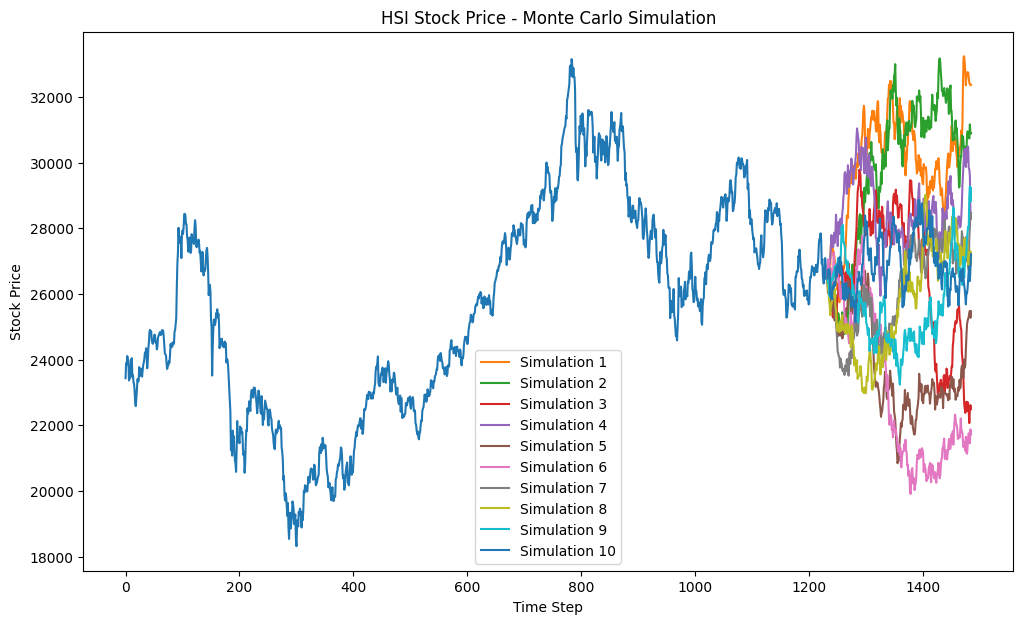

In [14]:
# TODO: Change from time step to date
plt.figure(figsize=(12, 7))
plt.plot(hsi_df["Adj Close"])
plt.ylabel("Stock Price")
plt.xlabel("Time Step")
plt.title("HSI Stock Price - Monte Carlo Simulation")
for i, sim in enumerate(hsi_simulations):
    plt.plot(len(hsi_df) + np.arange(1, 253+1), sim, label=f'Simulation {i+1}')
plt.legend()
plt.show()

The above visualization of 10 simulations gives a rough idea of how our simulation works. Above, we simulated 10 paths starting from 12 Nov 2019 lasting for 252 working days (1 year). With the simulations, we can then estimate the expected stock price and volatility at time T.

Our payoff function for the USD Outperformance Certification is defined below:

In [15]:
def note_payoff(path, initial=28523.35, parti=1.57, denom=1000):
    T = len(path)
    if path[T-1] >= initial:
        return denom * (1 + parti * (path[T-1]/initial - 1))
    else:
        return denom * path[T-1] / initial

## Simulation and Derivative Pricing

Now that we are aware of how the simulations work, we attempt simulation from our start date (22 Nov 2019) until the final fixing date (22 Mar 2021). This is calculated to be 394 working days in Hong Kong (inclusive of end date) using the website: https://www.timeanddate.com/date/workdays.html.

In [16]:
r = 0.0155
v = r - sigma**2 / 2
n_sim = 10000
T_minus_t = 394 / 252 # No. of trading days in Hong Kong between 22 Nov 2019 and 22 Mar 2021

For each simulation, we perform 10,000 simulations, using a risk-free interest rate of 1.55%.

We first simulate data using the Monte Carlo method below.

In [17]:
np.random.seed(4518)
hsi_simulations = simulate_gbm_exact(n_sim, S_t, v, sigma, dt, T_minus_t)
payoffs = np.array([note_payoff(sim) for sim in hsi_simulations])
sim_notes = np.exp(-r * T_minus_t) * payoffs
expected_note_value = np.mean(sim_notes)
var_note_value = np.var(sim_notes) / n_sim
print(expected_note_value, var_note_value, expected_note_value-1.96*np.sqrt(var_note_value), expected_note_value+1.96*np.sqrt(var_note_value))

962.7528019642689 7.227507086584449 957.4835333979664 968.0220705305713


Next, we simulate using the antithetic variate method:

In [18]:
np.random.seed(4518)
hsi_simulations_av = simulate_gbm_exact_av(n_sim//2, S_t, v, sigma, dt, T_minus_t)
payoffs_av = np.array([note_payoff(sim) for sim in hsi_simulations_av])
sim_notes_av = np.exp(-r * T_minus_t) * payoffs_av
expected_note_value_av = np.mean(sim_notes_av)
var_note_value_av = np.var(sim_notes_av) / n_sim
print(expected_note_value_av, var_note_value_av, expected_note_value_av-1.96*np.sqrt(var_note_value_av), expected_note_value_av+1.96*np.sqrt(var_note_value_av))

963.6862279996177 7.315839600718723 958.3848574777506 968.9875985214848


We perform simulations using the stratified sampling method next, with 5 strata and 2000 simulations per strata.

In [19]:
np.random.seed(4518)
n_strata = 5
n_sim_strata = n_sim // n_strata
hsi_simulations_ss = simulate_gbm_1_shoot_ss(n_strata, n_sim_strata, S_t, v, sigma, T_minus_t)
payoffs_ss = np.array([note_payoff(sim) for sim in hsi_simulations_ss])
sim_notes_ss = np.exp(-r * T_minus_t) * payoffs_ss
expected_note_value_ss = np.mean(sim_notes_ss)
var_note_value_ss = np.var(sim_notes_ss) / n_sim
print(expected_note_value_ss, var_note_value_ss, expected_note_value_ss-1.96*np.sqrt(var_note_value_ss), expected_note_value_ss+1.96*np.sqrt(var_note_value_ss))

962.375099235782 7.188003455919127 957.1202506103449 967.6299478612192


Next, we simulate data using the control variate method. We first use 100 simulations (Monte Carlo method) to calculate our c*. This c* is used in calculating the discounted note price for every generated path. As we see below, the control variate method achieves the lowest variance.

In [20]:
np.random.seed(4518)
n1 = 100
hsi_simulations_pre = simulate_gbm_exact(n1, S_t, v, sigma, dt, T_minus_t)
payoffs_pre = np.array([note_payoff(sim) for sim in hsi_simulations_pre])
sim_notes_pre = np.exp(-r * T_minus_t) * payoffs_pre
c = -np.cov(sim_notes_pre, hsi_simulations_pre[:,-1])[0,1] / (S_t**2 * np.exp(2*r*T_minus_t) * (np.exp(sigma**2*T_minus_t)-1))

hsi_simulations_cv = simulate_gbm_exact(n_sim, S_t, v, sigma, dt, T_minus_t)
payoffs_cv = np.array([note_payoff(sim) for sim in hsi_simulations_cv])
sim_notes_cv = np.exp(-r * T_minus_t) * payoffs_cv + c*(hsi_simulations_cv[:,-1] - S_t*np.exp(r*T_minus_t))
expected_note_value_cv = np.mean(sim_notes_cv)
var_note_value_cv = np.var(sim_notes_cv) / n_sim
print(expected_note_value_cv, var_note_value_cv, expected_note_value_cv-1.96*np.sqrt(var_note_value_cv), expected_note_value_cv+1.96*np.sqrt(var_note_value_cv))

963.8846621569363 1.0073925447059544 961.9174308030426 965.85189351083


Finally, we use the EMS method for simulation below:

In [21]:
np.random.seed(4518)
hsi_simulations_ems = simulate_gbm_ems(hsi_simulations, dt, r)
payoffs_ems = np.array([note_payoff(sim) for sim in hsi_simulations_ems])
sim_notes_ems = np.exp(-r * T_minus_t) * payoffs_ems
expected_note_value_ems = np.mean(sim_notes_ems)
var_note_value_ems = np.var(sim_notes_ems) / n_sim
print(expected_note_value_ems, var_note_value_ems, expected_note_value_ems-1.96*np.sqrt(var_note_value_ems), expected_note_value_ems+1.96*np.sqrt(var_note_value_ems))

963.3129446069782 7.239903061935126 958.0391592868566 968.5867299270999
